In [1]:

import warnings
#warnings.filterwarnings('ignore')

import sys, os
import importlib.util 
sys.path.append(os.environ['TOOLS_PATH']) 
spec = importlib.util.spec_from_file_location("tradetestlib","C:\\Users\\JB\\Desktop\\Alpha\\Repositories\\Modules\\Generic\\TradeTestLib\\tradetestlib\\__init__.py")
tradetestlib = importlib.util.module_from_spec(spec)
sys.modules['tradetestlib'] = tradetestlib
spec.loader.exec_module(tradetestlib)
from sklearn.linear_model import LinearRegression 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime as dt, timedelta 

#import tradetestlib
from tqdm import tqdm
import MetaTrader5 as mt5
import tools
import btobject as bt 
import dbloader as db 

loader = db.DBLoader()

import statsmodels.api as sm  
from statsmodels.tsa.stattools import adfuller 


In [87]:
def load_csv(ticker):
    directory = 'ph_stocks'
    path = os.path.join(f'{ticker}.csv')
    df = pd.read_csv(path)
    df.index = pd.to_datetime(df['Date']) 
    df = df[::-1] 
    if df['Price'].dtype == 'float':
        return df['Price']
    if df['Price'].str.contains(','):
        df = df['Price'].str.replace(',','').astype('float') 
    else:
        df = df['Price'].astype('float')
    return df 
ph_tickers = ['MBT','BDO']

# GOOD PAIRS: MBT + BDO, MBT + BPI

df = pd.DataFrame(columns=ph_tickers)

df[ph_tickers[0]] = load_csv(ph_tickers[0])
df[ph_tickers[1]] = load_csv(ph_tickers[1]) 

df.head()

,MBT,BDO
Date,,
2020-01-06,64.55,128.17
2020-01-07,65.10,128.17
2020-01-08,64.60,125.69
2020-01-09,65.90,125.69
2020-01-10,67.00,126.52


Text(0.5, 1.0, 'MBT vs BDO')

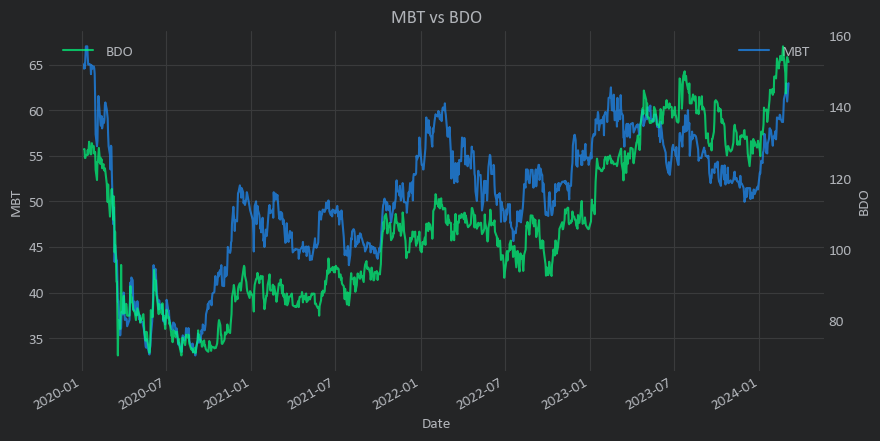

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
df[ph_tickers[0]].plot(ax=ax, color ='dodgerblue', alpha=0.7)
plt.ylabel(ph_tickers[0])
plt.legend(labels=[ph_tickers[0]])

ax1=ax.twinx()
df[ph_tickers[1]].plot(ax=ax1, color ='springgreen', alpha=0.7)
plt.ylabel(ph_tickers[1])
plt.legend(labels=[ph_tickers[1]])

plt.grid()
plt.title(f'{ph_tickers[0]} vs {ph_tickers[1]}')

In [89]:
Y = df[ph_tickers[0]]
x = df[ph_tickers[1]]

X = sm.add_constant(x)

result = sm.OLS(Y, X).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    MBT   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     2239.
Date:                Mon, 04 Mar 2024   Prob (F-statistic):          1.92e-259
Time:                        14:48:23   Log-Likelihood:                -2889.1
No. Observations:                1021   AIC:                             5782.
Df Residuals:                    1019   BIC:                             5792.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.3820      0.647     31.511      0.0

In [90]:
hedge_ratio = result.params[1]
print(f"Hedge Ratio: {hedge_ratio}")
print(result.params)

Hedge Ratio: 0.2818601121029268
const    20.382021
BDO       0.281860
dtype: float64


In [91]:
df['spread'] = Y - hedge_ratio * x 

df['log_return'] = np.log(df['spread'] / df['spread'].shift(1)) 

df.head()


,MBT,BDO,spread,log_return
Date,,,,
2020-01-06,64.55,128.17,28.423989,NaN
2020-01-07,65.10,128.17,28.973989,0.019165
2020-01-08,64.60,125.69,29.173003,0.006845
2020-01-09,65.90,125.69,30.473003,0.043597
2020-01-10,67.00,126.52,31.339059,0.028024


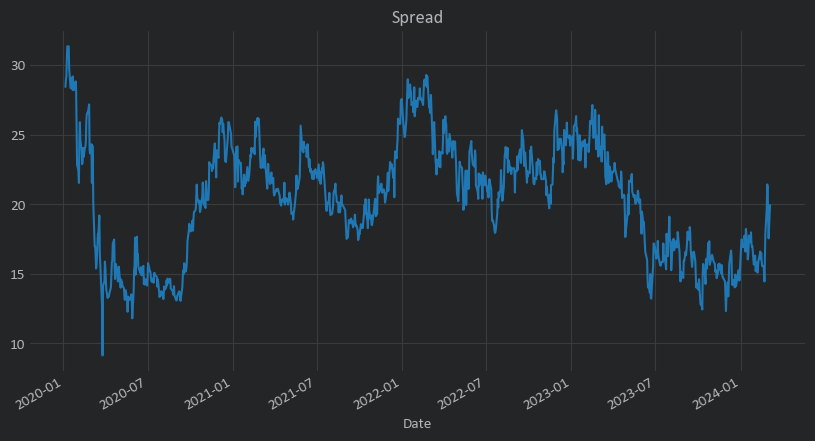

In [92]:
df['spread'].plot(figsize=(10,5))
plt.title('Spread')
plt.show()

In [93]:
# Test the spread for stationarity using ADF 
adf = adfuller(df['spread'], maxlag=1)
test_statistic, p_value, _, _, critical_value, _ = adf
print(f"ADF Result Parameters \n{adf}\n")

print(f"Test Statistic: {test_statistic:.4f}")

print(f"Critical Value: {critical_value['5%']:.4f}")

print(f"P-Value: {p_value*100:.4f}%")

ADF Result Parameters 
(-3.5951802048827832, 0.00585384325174615, 1, 1019, {'1%': -3.436783610904024, '5%': -2.864380523665108, '10%': -2.568282420632131}, 2725.748976312836)

Test Statistic: -3.5952
Critical Value: -2.8644
P-Value: 0.5854%


In [94]:
# Print Stationarity 
def is_stationary(p_value):
    if p_value < 0.05: 
        print(f"Series is Stationary. (p-value {p_value*100:.4f}%)")
    else:
        print(f"Series is NOT Stationary. (p-value {p_value*100:.4f}%)")
    return 
is_stationary(p_value)

Series is Stationary. (p-value 0.5854%)


Text(0.5, 1.0, 'Skew and Z-Score')

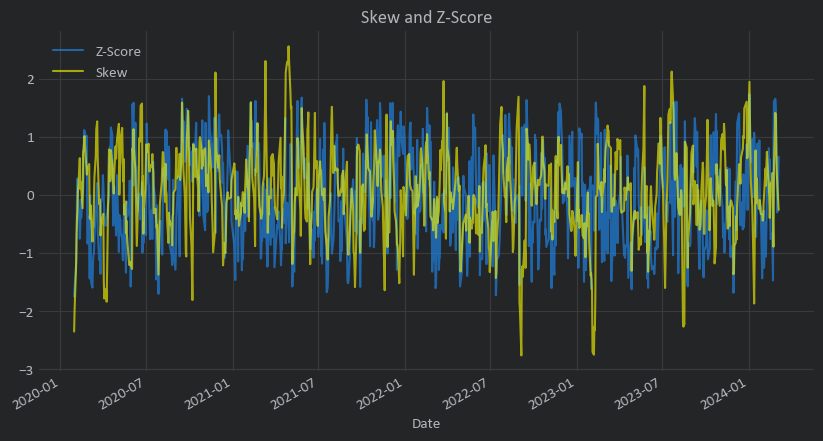

In [152]:
# Compute the Z-Score as: 
# Z = ( x - mu ) / sigma 

# Compute Mean and Std using window specified, and with exponential moving window (Exponential Moving Average)

window = 10 
df['mean'] = df['spread'].ewm(span=window).mean()
df['std'] = df['spread'].ewm(span=window).std()
df['skew'] = df['spread'].rolling(window).skew() 

# Drop Null Values 
df = df.dropna()

# Compute Z-Score 
df['z_score'] = (df['spread'] - df['mean']) / df['std']

# Set Z-Score Limits (-1, 1)
# Z Limits 
df['z_up'] = 1.0 
df['z_down'] = -1.0 

# Set Skew Limits (-0.6, 0.6)
df['skew_up'] = -0.6 
df['skew_down'] = 0.6

fig, ax = plt.subplots(figsize=(10, 5))
df['z_score'].plot(color='dodgerblue', alpha=0.6)
df['skew'].plot(color='yellow',alpha=0.6)
plt.legend(labels=['Z-Score','Skew'])

plt.title('Skew and Z-Score')

In [96]:
# SIGNALS

def build_signal(data, column_name, entry_mask, exit_mask, entry_signal, exit_signal):
    sig = data
    sig[column_name] = np.nan 
    sig.loc[entry_mask, column_name] = entry_signal 
    sig.loc[exit_mask, column_name] = exit_signal 
    sig[column_name] = sig[column_name].ffill()
    sig[column_name] = sig[column_name].fillna(0)
    return sig 

long_entry = (df['z_score'] <= df['z_down']) & (df['skew'] <= df['skew_down'])
long_exit = (df['z_score'] >= 0) & (df['skew'] >= 0)

short_entry = (df['z_score'] >= df['z_up']) & (df['skew'] >= df['skew_up'])
short_exit = (df['z_score'] <= 0) & (df['skew'] <= 0)

df = build_signal(data = df, column_name= 'long_pos', entry_mask=long_entry, exit_mask=long_exit, entry_signal= 1, exit_signal= 0)
df = build_signal(data = df, column_name= 'short_pos', entry_mask=short_entry, exit_mask = short_exit, entry_signal=-1, exit_signal=0)
df['total_pos'] = df['long_pos'] + df['short_pos']

df.head()

,MBT,BDO,spread,log_return,mean,std,skew,z_score,z_up,z_down,skew_up,skew_down,long_pos,short_pos,total_pos
Date,,,,,,,,,,,,,,,
2020-01-17,65.05,130.24,28.340539,-0.017769,29.443531,1.104801,0.711534,-0.998363,1.0,-1.0,-0.6,0.6,0.0,0.0,0.0
2020-01-20,65.00,127.35,29.105115,0.026621,29.374397,0.992705,0.778696,-0.271261,1.0,-1.0,-0.6,0.6,0.0,0.0,0.0
2020-01-21,63.95,126.68,28.243961,-0.030034,29.148538,1.008094,0.626578,-0.897314,1.0,-1.0,-0.6,0.6,0.0,0.0,0.0
2020-01-22,64.95,126.93,29.173496,0.032381,29.153437,0.901842,0.626472,0.022243,1.0,-1.0,-0.6,0.6,0.0,0.0,0.0
2020-01-23,64.80,129.83,28.206102,-0.033722,28.970152,0.900853,1.023492,-0.848142,1.0,-1.0,-0.6,0.6,0.0,0.0,0.0


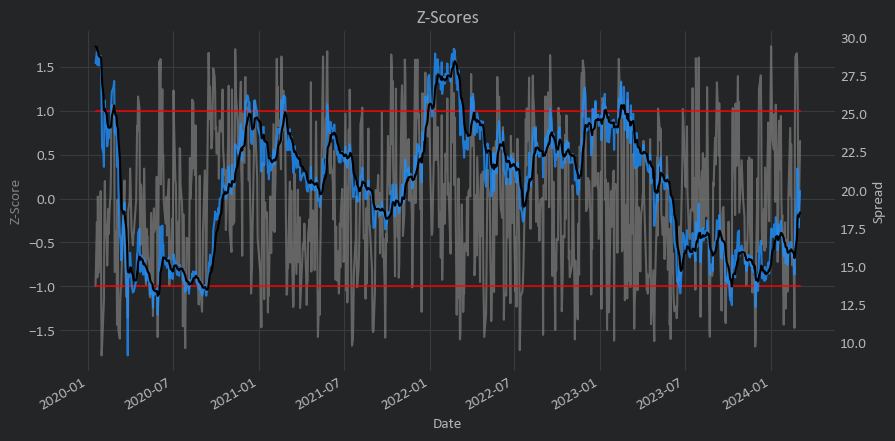

In [97]:
# Plot Z-Scores 
fig, ax = plt.subplots(figsize=(10, 5))
df['z_score'].plot(ax=ax, color='grey',alpha = 0.7)
df['z_up'].plot(ax=ax, color = 'red', alpha=0.7)
df['z_down'].plot(ax=ax, color = 'red', alpha=0.7)
ax.set_ylabel('Z-Score', color='grey')

ax1=ax.twinx()
df['spread'].plot(ax=ax1, color='dodgerblue', alpha=0.8)
df['mean'].plot(ax=ax1, color='black')
ax1.set_ylabel('Spread')
plt.title('Z-Scores')
plt.grid()
plt.show()

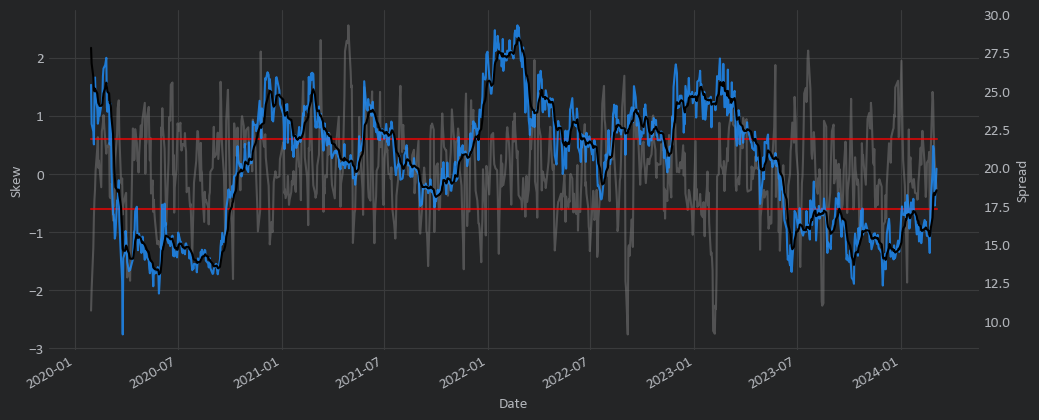

In [161]:
fig, ax = plt.subplots(figsize=(12, 5))
df['skew'].plot(ax=ax, color = 'grey', alpha=0.5)
df['skew_up'].plot(ax=ax, color = 'red', alpha=0.7)
df['skew_down'].plot(ax=ax, color = 'red', alpha=0.7)
ax.set_ylabel('Skew')

ax1=ax.twinx()
df['spread'].plot(ax=ax1, color='dodgerblue', alpha=0.8)
df['mean'].plot(ax=ax1, color='black')
ax1.set_ylabel('Spread')

plt.grid()

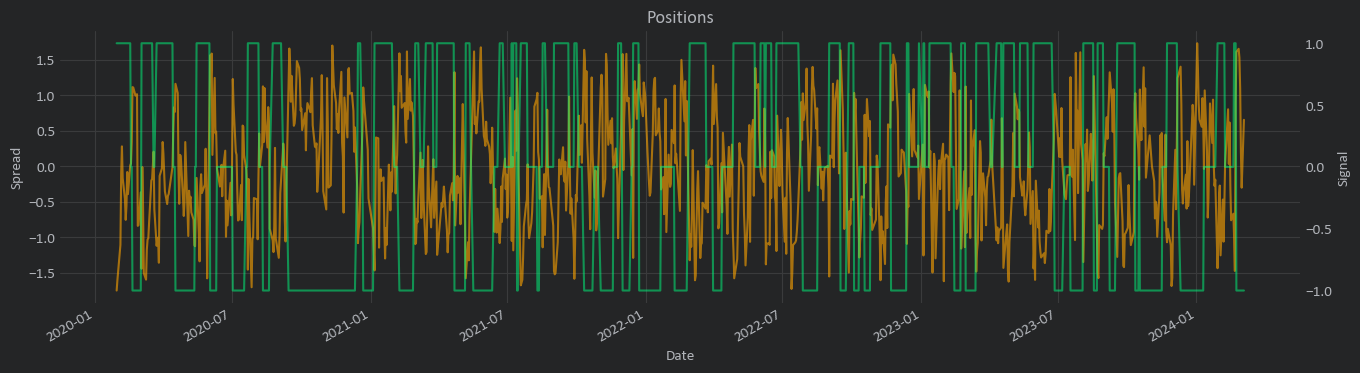

In [160]:
# Plot Trading Positions 

fig, ax = plt.subplots(figsize=(16, 4))
df['z_score'].plot(alpha = 0.6, color='orange')
plt.ylabel('Spread')

ax1=ax.twinx()
df['total_pos'].plot(ax=ax1, color ='springgreen',alpha=0.5)

ax1.set_ylabel('Signal')
plt.grid()
plt.title('Positions')
plt.show()

Text(0.5, 1.0, 'Equity Curve: MBT')

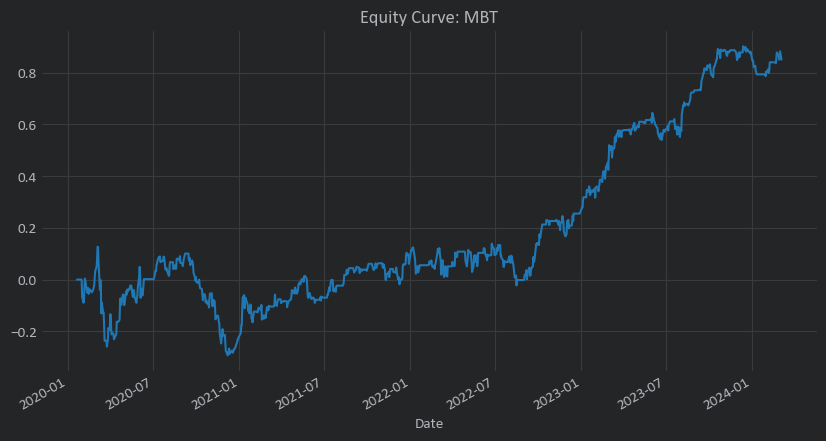

In [148]:
## APPLYING SIGNALS 
## (LONG MBT, SHORT BDO) & (SHORT MBT, LONG BDO)

mbt_signal = df[['MBT','total_pos']]
mbt_signal.columns = ['MBT','position']
mbt_signal['position'] = mbt_signal['position'].shift(1)
mbt_signal['log_returns'] = np.log(mbt_signal['MBT']/mbt_signal['MBT'].shift(1)) 
mbt_signal['strategy'] = mbt_signal['position'] * mbt_signal['log_returns']
mbt_signal['strategy'].cumsum().plot(figsize=(10, 5))
plt.title('Equity Curve: MBT')

Text(0.5, 1.0, 'Equity Curve: BDO')

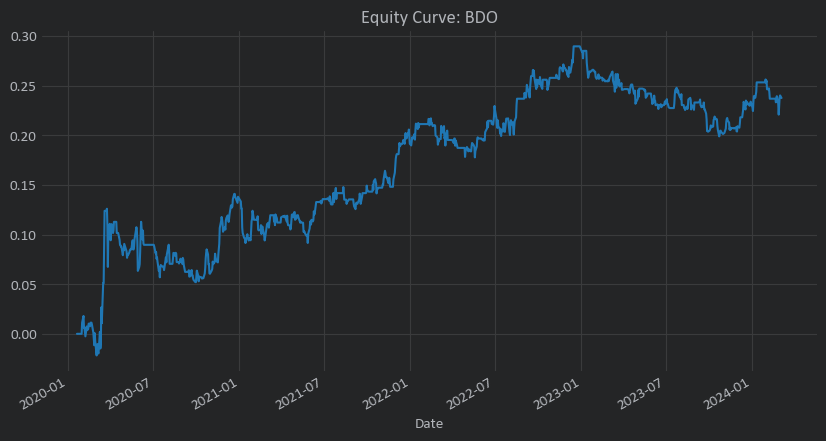

In [149]:
bdo_signal = df[['BDO','total_pos']]
bdo_signal.columns = ['BDO','position']
bdo_signal['position'] = bdo_signal['position'].shift(1) * -1 # Invert signal

bdo_signal['log_returns'] = np.log(bdo_signal['BDO']/bdo_signal['BDO'].shift(1)) 
bdo_signal['strategy'] = bdo_signal['position'] * bdo_signal['log_returns'] * hedge_ratio
bdo_signal['strategy'].cumsum().plot(figsize=(10, 5))
plt.title('Equity Curve: BDO')

Text(0.5, 1.0, 'Equity Curve: Pairs Trading MBT - BDO')

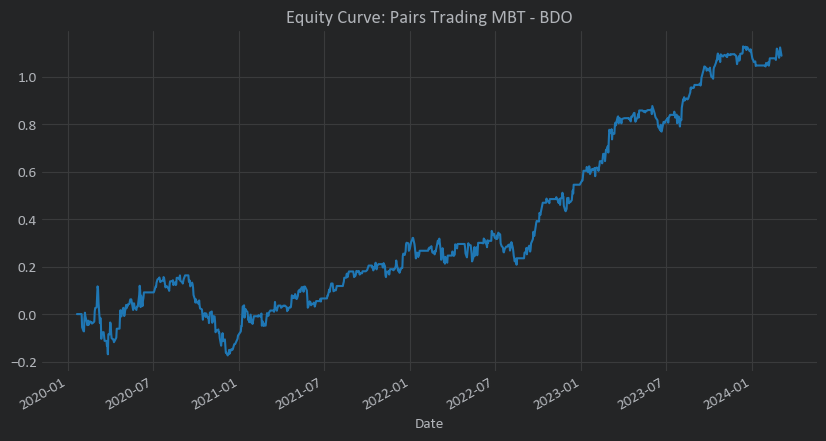

In [145]:
net_returns = mbt_signal['strategy'] + bdo_signal['strategy'] 
net_returns.cumsum().plot(figsize=(10, 5))
plt.title('Equity Curve: Pairs Trading MBT - BDO')



Text(0.5, 0, 'Year')

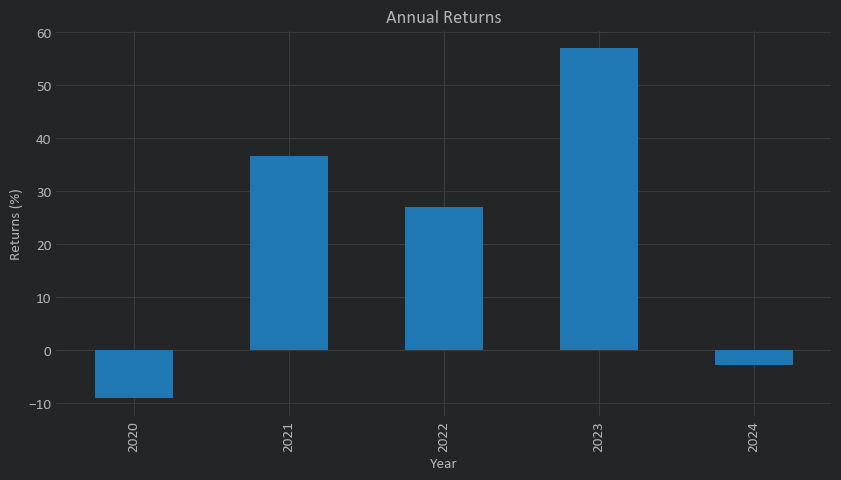

In [143]:
(net_returns.groupby(net_returns.index.year).sum() * 100).plot(kind='bar', figsize=(10, 5))
plt.title('Annual Returns')
plt.ylabel('Returns (%)')
plt.xlabel('Year')

In [144]:

strategy_mean = net_returns.mean()
strategy_std = net_returns.std()

# Sharpe Ratio 
risk_free_rate = 0.05 # Assume 5.0% per year 

# Daily Sharpe Ratio 
sharpe_daily = (strategy_mean - (risk_free_rate/252)) / strategy_std 
print(f"Daily Sharpe: {sharpe_daily:.4f}")

# Annualized Sharpe Ratio 
sharpe_annual = sharpe_daily * np.sqrt(252)
print(f"Annual Sharpe Ratio: {sharpe_annual:.4f}")

Daily Sharpe: 0.0534
Annual Sharpe Ratio: 0.8479
